https://github.com/inhovation97/PyTorch_Study/blob/main/week_8_%EC%8B%A4%EC%8A%B5/resnet50_acc_98.ipynb

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(777)
if device == 'cuda':
  torch.cuda.manual_seed_all(777)

print(device)

cuda


In [3]:
transform = transforms.Compose([
                                 transforms.ToTensor()
])

trainset = torchvision.datasets.CIFAR10(root='./cifar10', train=True, download=True, transform=transform) # trainset
print(trainset.data.shape)

Files already downloaded and verified
(50000, 32, 32, 3)


In [4]:
train_data_mean = trainset.data.mean(axis=(0,1,2))
train_data_std = trainset.data.std(axis=(0,1,2))

train_data_mean /= 255
train_data_std /= 255

print(train_data_mean, train_data_std)

[0.49139968 0.48215841 0.44653091] [0.24703223 0.24348513 0.26158784]


In [5]:
import matplotlib.pyplot as plt
import numpy as np

transform_train = transforms.Compose([
                                      transforms.RandomCrop(32, padding=4),
                                      transforms.ToTensor(),
                                      transforms.Normalize(train_data_mean, train_data_std)
])

transform_test =  transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize(train_data_mean, train_data_std)
])

trainset = torchvision.datasets.CIFAR10(root='./cifar10',train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=256,
                                          shuffle=True, num_workers=0)

testset = torchvision.datasets.CIFAR10(root='./cifar10',train=False,
                                        download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(trainset, batch_size=256,
                                          shuffle=True, num_workers=0)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [6]:
from torch.utils.tensorboard import SummaryWriter
import datetime
from tensorflow import summary # 텐서보드에 기록하기 위한 함수

%load_ext tensorboard

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


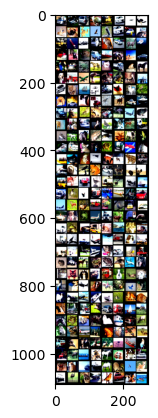

In [7]:
# 타임스탬프
time_stamp = str(datetime.datetime.now().timestamp())
log_dir = 'runs/resnet_ex_' + time_stamp
writer = SummaryWriter(log_dir)

# dataiter
dataiter = iter(trainloader)
images, labels = dataiter.next()

# 이미지 그리드 만들기
img_grid = torchvision.utils.make_grid(images/2 + 0.5)

# 그리드 시각화 함수
def imshow(img):
    npimg = img.numpy() # 시각화에 넘파이 필수
    plt.imshow(np.transpose(npimg, (1,2,0))) # 시각화에 width, height, channel 배열 정리 필수
    plt.show()

imshow(img_grid)

# 텐보에 올릴 이름과 이미지 그리드 인자 입력
writer.add_image(datetime.datetime.now().strftime('%Y%m%d-%H%M%S'), img_grid) # tesnsorboard의 image에 등록됨

In [8]:
lr = 0.001
epochs = 30
optimizer = 'Adam'

# 데이터 이름을 파라미터로 부여
model_parameter = str(optimizer+'batch_size:{:.0f}, lr:{:.5f}'.format(trainloader.batch_size, lr))

# 텐서보드에 올릴 데이터 디렉토리 경로
train_log_dir = 'logs/tensorboard/train'+model_parameter
test_log_dir = 'logs/tensorboard/test'+model_parameter

# 위 경로로 데이터를 텐보에 올릴 파일을 만듦
train_summary_writer = summary.create_file_writer(train_log_dir)
test_summary_writer =  summary.create_file_writer(test_log_dir)

In [9]:
# 텐보 부르기
# 좀 걸림
%tensorboard --logdir {log_dir}

In [9]:
import torchvision.models.resnet as resnet

# 미리 정의
conv1x1 = resnet.conv1x1
Bottleneck = resnet.Bottleneck

In [16]:
resnet50 = torchvision.models.resnet50(pretrained=False).to(device)

## Training

In [17]:

# config 모델 파라미터 인자를 만들기위한 클래스
class Config:
  def __init__(self, **kwargs):
    for key, value in kwargs.items():
      setattr(self, key, value)
    

# 파라미터 클래스
config = Config(
    trainloader = trainloader,
    testloader = testloader,
    model = resnet50,
    device = device,
    optimizer = torch.optim.Adam(resnet50.parameters(), lr=lr),
    criterion= nn.CrossEntropyLoss().to(device),
    globaliter = 0
)

In [18]:
PATH = './model.pt'

In [19]:
class train_test():
      def __init__(self, config):
        self.trainloader = config.trainloader
        self.testloader = config.testloader
        self.model = config.model
        self.device = config.device
        self.optimizer = config.optimizer
        self.criterion = config.criterion
        self.globaliter = config.globaliter
        print(len(trainloader))
      def train(self, epochs, log_interval):
          self.model.train()
          for epoch in range(1, epochs + 1 ):  # loop over the dataset multiple times
              running_loss = 0.0
              lr_sche.step()
              for i, data in enumerate(self.trainloader, 0):
                  # get the inputs
                  self.globaliter += 1
                  inputs, labels = data
                  inputs = inputs.to(self.device)
                  labels = labels.to(self.device)

                  # zero the parameter gradients
                  self.optimizer.zero_grad()

                  # forward + backward + optimize
                  outputs = self.model(inputs)
                  loss = self.criterion(outputs, labels)
                  loss.backward()
                  self.optimizer.step()
                  running_loss += loss.item()
                  # 30 iteration마다 출력
                  if i % log_interval == log_interval -1 : # i는 1에포크의 iteration
                    print('Train Epoch: {} [{}/{} ({:.0f}%)]\tlearningLoss: {:.6f}\twhole_loss: {:.6f} '.format(
                        epoch, i*len(inputs), len(self.trainloader.dataset),
                        100. * i*len(inputs) / len(self.trainloader.dataset), 
                        running_loss / log_interval,
                        loss.item()))
                    running_loss = 0.0

                    with train_summary_writer.as_default():
                        summary.scalar('loss', loss.item() , step = self.globaliter)

              with torch.no_grad():
                  self.model.eval()
                  correct = 0
                  total = 0
                  test_loss = 0
                  acc = []
                  for k, data in enumerate(self.testloader, 0):
                    images, labels = data
                    images = images.to(self.device)
                    labels = labels.to(self.device)
                    outputs = self.model(images)

                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
                    test_loss += self.criterion(outputs, labels).item()
                    acc.append(100 * correct/total)

                  print('\nTest set : Average loss:{:.4f}, Accuracy: {}/{}({:.0f}%)\n'.format(
                      test_loss, correct, total, 100 * correct/total
                  ))
                  with test_summary_writer.as_default():
                      summary.scalar('loss', test_loss , step = self.globaliter)
                      summary.scalar('accuracy', 100 * correct/total , step = self.globaliter)  
##                      if acc [k] > 60 and acc[k] > acc[k-1]:
#                         torch.save({
#                                     'epoch': epoch,
#                                     'model_state_dict': self.model.state_dict(),
#                                     'optimizer_state_dict': self.optimizer.state_dict(),
#                                     'loss': test_loss
#                                     }, PATH)
                         
      print('Finished Training')

Finished Training


In [20]:
ready_to_train=train_test(config)

196


In [22]:
lr_sche = optim.lr_scheduler.StepLR(config.optimizer, step_size=5000, gamma=0.5) # 20 step마다 lr조정
epochs = 100
log_interval = 58

ready_to_train.train(epochs, log_interval)

Train Epoch: 1 [14592/50000 (29%)]	learningLoss: 2.395126	whole_loss: 1.555439 
Train Epoch: 1 [29440/50000 (59%)]	learningLoss: 1.267119	whole_loss: 1.217168 
Train Epoch: 1 [44288/50000 (89%)]	learningLoss: 1.061088	whole_loss: 0.974576 

Test set : Average loss:177.4947, Accuracy: 34154/50000(68%)

Train Epoch: 2 [14592/50000 (29%)]	learningLoss: 1.137780	whole_loss: 0.825192 
Train Epoch: 2 [29440/50000 (59%)]	learningLoss: 0.815482	whole_loss: 0.885658 
Train Epoch: 2 [44288/50000 (89%)]	learningLoss: 0.746588	whole_loss: 0.787647 

Test set : Average loss:138.8024, Accuracy: 37586/50000(75%)

Train Epoch: 3 [14592/50000 (29%)]	learningLoss: 0.682919	whole_loss: 0.709244 
Train Epoch: 3 [29440/50000 (59%)]	learningLoss: 0.648442	whole_loss: 0.698782 
Train Epoch: 3 [44288/50000 (89%)]	learningLoss: 0.617474	whole_loss: 0.673996 

Test set : Average loss:119.5724, Accuracy: 39346/50000(79%)

Train Epoch: 4 [14592/50000 (29%)]	learningLoss: 0.566915	whole_loss: 0.626713 
Train Epoch

# feature check

In [23]:
import torch.nn as nn
resnet50.fc = nn.Identity()

In [26]:
feature_arr = []
label_arr = []
for images, l in testloader:
    images = images.to(device)

    #with autocast(enabled=args.fp16_precision):
    features = resnet50(images)
        
    feature_arr.append(features.cpu().detach().numpy())
    label_arr.append(l)

feature_arr = np.concatenate(feature_arr)
label_arr = np.concatenate(label_arr)

[t-SNE] Computing 601 nearest neighbors...
[t-SNE] Indexed 50000 samples in 0.031s...
[t-SNE] Computed neighbors for 50000 samples in 59.885s...
[t-SNE] Computed conditional probabilities for sample 1000 / 50000
[t-SNE] Computed conditional probabilities for sample 2000 / 50000
[t-SNE] Computed conditional probabilities for sample 3000 / 50000
[t-SNE] Computed conditional probabilities for sample 4000 / 50000
[t-SNE] Computed conditional probabilities for sample 5000 / 50000
[t-SNE] Computed conditional probabilities for sample 6000 / 50000
[t-SNE] Computed conditional probabilities for sample 7000 / 50000
[t-SNE] Computed conditional probabilities for sample 8000 / 50000
[t-SNE] Computed conditional probabilities for sample 9000 / 50000
[t-SNE] Computed conditional probabilities for sample 10000 / 50000
[t-SNE] Computed conditional probabilities for sample 11000 / 50000
[t-SNE] Computed conditional probabilities for sample 12000 / 50000
[t-SNE] Computed conditional probabilities for s

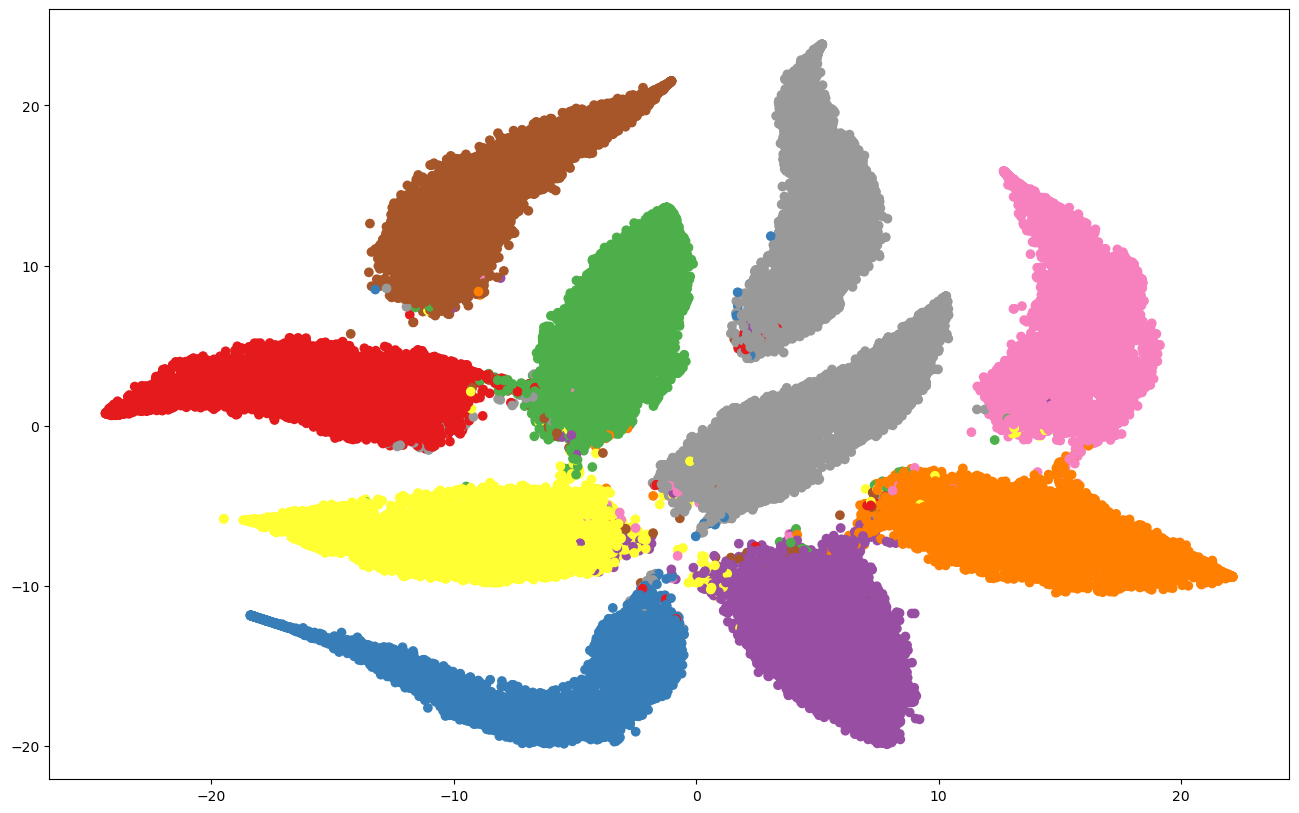

In [27]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=1, perplexity=200, n_iter=500)
# n_components : the number of reduced dimension.
# perplexity : (roughly) number of neighbors.
tsne_results = tsne.fit_transform(feature_arr)

plt.figure(figsize=(16,10))
plt.scatter(tsne_results[:,0], tsne_results[:,1], c=label_arr, cmap='Set1')
plt.show()

In [28]:
resnet50

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 